In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
#dl libraraies
from tensorflow.python.keras import backend as k
from tensorflow.keras import backend
#from keras import backend as K
from tensorflow_core.python.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn
import cv2                  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

Using TensorFlow backend.


In [2]:
from mtcnn.mtcnn import MTCNN
from matplotlib.patches import Rectangle
from matplotlib.patches import Circle

In [3]:
subjects = ["","ab","bhumra","bindu","chahal","chiru","dhawan","dhoni","gayle","indu","koti","narayana","prabhas","rajini","rana","ravi","redd","rohit","sachin","samar","siva","surya","velu","venkey","vk"]

In [4]:
def detect_face(img):
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(img, scaleFactor=1.3, minNeighbors=5);
    if (len(faces) == 0):
        return None, None
    (x, y, w, h) = faces[0]
    return img[y:y+w, x:x+h], faces[0]
    

In [5]:
def prepare_training_data(data_folder_path):
    dirs = os.listdir(data_folder_path)
    faces = []
    labels = []
    IMG_SIZE=32
    for dir_name in dirs:
        if not dir_name.startswith("s"):
            continue;
        label = int(dir_name.replace("s", ""))
        subject_dir_path = data_folder_path + "/" + dir_name
        subject_images_names = os.listdir(subject_dir_path)
        for image_name in subject_images_names:
            if image_name.startswith("."):
                continue;
            image_path = subject_dir_path + "/" + image_name
            image = cv2.imread(image_path)
            cv2.imshow("Training on image...", image)
            cv2.waitKey(100)
            face, rect = detect_face(image)
            if face is not None:
                img = cv2.resize(face, (IMG_SIZE,IMG_SIZE))  
                faces.append(img)
                labels.append(label)
                cv2.destroyAllWindows()
                cv2.waitKey(1)
                cv2.destroyAllWindows()
    return faces, labels

In [6]:
faces, labels = prepare_training_data("C:/Users/ntadi/pictures")
print("Total faces: ", len(faces))
print("Total labels: ", len(labels))

Total faces:  799
Total labels:  799


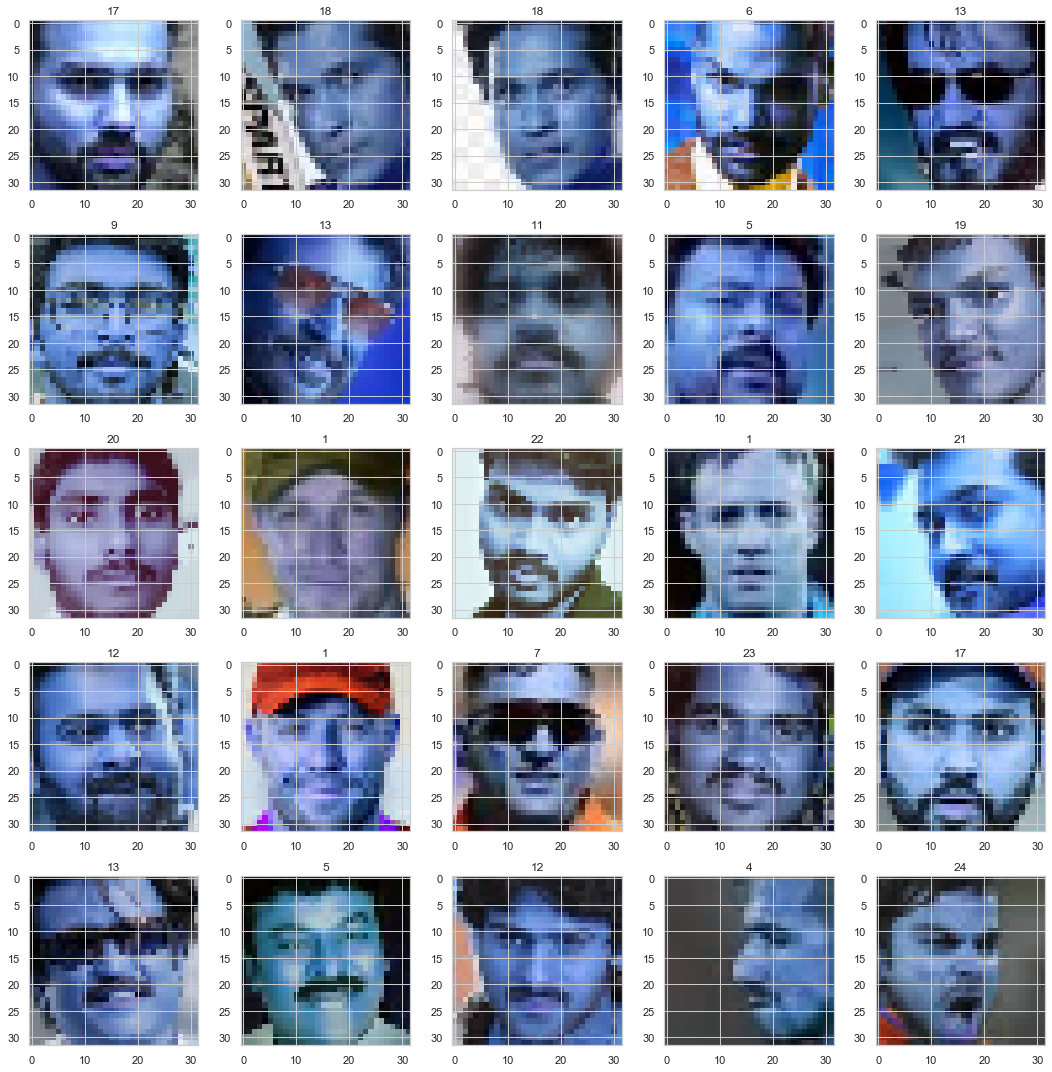

In [7]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(labels))
        ax[i,j].imshow(faces[l])
        ax[i,j].set_title(labels[l])
        
plt.tight_layout()

In [8]:
le=LabelEncoder()
Y=list(labels)
Y=le.fit_transform(labels)
Y=to_categorical(Y,24)
X=np.array(faces)
X=X/255

In [9]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.2,random_state=45)

In [10]:
x_train.shape

(639, 32, 32, 3)

In [11]:
x_test.shape

(160, 32, 32, 3)

In [12]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(32,32,3)))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(Conv2D(32,(3,3),activation='relu'))
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128,(3,3),activation='relu'))
#model.add(Conv2D(128,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(24,activation="softmax"))

In [13]:
batch_size=256
epochs=50
from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [14]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [15]:
model.compile(optimizer=Adam(0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [16]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = 500, validation_data = (x_test,y_test), verbose = 2, steps_per_epoch=x_train.shape[0] // batch_size)

Epoch 1/500
 - 1s - loss: 3.1686 - accuracy: 0.0574 - val_loss: 3.1447 - val_accuracy: 0.0500
Epoch 2/500
 - 1s - loss: 3.1326 - accuracy: 0.0566 - val_loss: 3.1061 - val_accuracy: 0.0500
Epoch 3/500
 - 1s - loss: 3.1078 - accuracy: 0.0731 - val_loss: 3.1012 - val_accuracy: 0.0875
Epoch 4/500
 - 1s - loss: 3.0575 - accuracy: 0.0809 - val_loss: 3.1008 - val_accuracy: 0.0625
Epoch 5/500
 - 1s - loss: 3.0885 - accuracy: 0.0705 - val_loss: 3.0996 - val_accuracy: 0.0625
Epoch 6/500
 - 1s - loss: 3.0689 - accuracy: 0.0684 - val_loss: 3.0991 - val_accuracy: 0.0625
Epoch 7/500
 - 1s - loss: 3.0683 - accuracy: 0.0705 - val_loss: 3.1114 - val_accuracy: 0.0625
Epoch 8/500
 - 1s - loss: 3.0768 - accuracy: 0.0684 - val_loss: 3.1011 - val_accuracy: 0.0625
Epoch 9/500
 - 1s - loss: 3.0434 - accuracy: 0.0757 - val_loss: 3.0922 - val_accuracy: 0.0875
Epoch 10/500
 - 1s - loss: 3.0604 - accuracy: 0.0888 - val_loss: 3.0848 - val_accuracy: 0.0875
Epoch 11/500
 - 1s - loss: 3.0343 - accuracy: 0.1074 - val_

Epoch 88/500
 - 1s - loss: 2.0961 - accuracy: 0.3457 - val_loss: 2.3886 - val_accuracy: 0.3187
Epoch 89/500
 - 1s - loss: 2.2276 - accuracy: 0.2950 - val_loss: 2.3839 - val_accuracy: 0.3313
Epoch 90/500
 - 1s - loss: 2.0780 - accuracy: 0.3420 - val_loss: 2.4219 - val_accuracy: 0.3438
Epoch 91/500
 - 1s - loss: 2.1004 - accuracy: 0.3359 - val_loss: 2.3212 - val_accuracy: 0.3125
Epoch 92/500
 - 1s - loss: 2.1614 - accuracy: 0.3031 - val_loss: 2.4459 - val_accuracy: 0.3250
Epoch 93/500
 - 1s - loss: 2.0571 - accuracy: 0.3359 - val_loss: 2.4251 - val_accuracy: 0.3187
Epoch 94/500
 - 1s - loss: 2.0403 - accuracy: 0.3574 - val_loss: 2.4339 - val_accuracy: 0.3063
Epoch 95/500
 - 1s - loss: 2.0886 - accuracy: 0.3446 - val_loss: 2.4749 - val_accuracy: 0.3313
Epoch 96/500
 - 1s - loss: 2.0601 - accuracy: 0.3473 - val_loss: 2.2811 - val_accuracy: 0.3250
Epoch 97/500
 - 1s - loss: 2.1392 - accuracy: 0.3184 - val_loss: 2.4202 - val_accuracy: 0.3000
Epoch 98/500
 - 1s - loss: 2.0160 - accuracy: 0.35

Epoch 174/500
 - 1s - loss: 1.3440 - accuracy: 0.5723 - val_loss: 2.0238 - val_accuracy: 0.5000
Epoch 175/500
 - 1s - loss: 1.3428 - accuracy: 0.5547 - val_loss: 2.0898 - val_accuracy: 0.4563
Epoch 176/500
 - 1s - loss: 1.2734 - accuracy: 0.5979 - val_loss: 2.1243 - val_accuracy: 0.4875
Epoch 177/500
 - 1s - loss: 1.3211 - accuracy: 0.5849 - val_loss: 2.0693 - val_accuracy: 0.5125
Epoch 178/500
 - 1s - loss: 1.2519 - accuracy: 0.6005 - val_loss: 2.1827 - val_accuracy: 0.4563
Epoch 179/500
 - 1s - loss: 1.3452 - accuracy: 0.5527 - val_loss: 2.0829 - val_accuracy: 0.4812
Epoch 180/500
 - 1s - loss: 1.3517 - accuracy: 0.5483 - val_loss: 2.0118 - val_accuracy: 0.4875
Epoch 181/500
 - 1s - loss: 1.3822 - accuracy: 0.5449 - val_loss: 2.1977 - val_accuracy: 0.5188
Epoch 182/500
 - 1s - loss: 1.2469 - accuracy: 0.5796 - val_loss: 2.1230 - val_accuracy: 0.4563
Epoch 183/500
 - 1s - loss: 1.3314 - accuracy: 0.5901 - val_loss: 2.1183 - val_accuracy: 0.4625
Epoch 184/500
 - 1s - loss: 1.2934 - acc

Epoch 260/500
 - 1s - loss: 0.9104 - accuracy: 0.7070 - val_loss: 2.0373 - val_accuracy: 0.5750
Epoch 261/500
 - 1s - loss: 0.9149 - accuracy: 0.6658 - val_loss: 2.2593 - val_accuracy: 0.4750
Epoch 262/500
 - 1s - loss: 1.0659 - accuracy: 0.6580 - val_loss: 2.0455 - val_accuracy: 0.5000
Epoch 263/500
 - 1s - loss: 0.9283 - accuracy: 0.7031 - val_loss: 1.9574 - val_accuracy: 0.5813
Epoch 264/500
 - 1s - loss: 0.9363 - accuracy: 0.6867 - val_loss: 2.0717 - val_accuracy: 0.5312
Epoch 265/500
 - 1s - loss: 0.8652 - accuracy: 0.7128 - val_loss: 1.9641 - val_accuracy: 0.5625
Epoch 266/500
 - 1s - loss: 1.0855 - accuracy: 0.6188 - val_loss: 2.3057 - val_accuracy: 0.4688
Epoch 267/500
 - 1s - loss: 0.9924 - accuracy: 0.6777 - val_loss: 2.0711 - val_accuracy: 0.5375
Epoch 268/500
 - 1s - loss: 0.8574 - accuracy: 0.6953 - val_loss: 2.0859 - val_accuracy: 0.5688
Epoch 269/500
 - 1s - loss: 0.9533 - accuracy: 0.6772 - val_loss: 2.1856 - val_accuracy: 0.5625
Epoch 270/500
 - 1s - loss: 0.9659 - acc

Epoch 346/500
 - 1s - loss: 0.6229 - accuracy: 0.7807 - val_loss: 2.5114 - val_accuracy: 0.5312
Epoch 347/500
 - 1s - loss: 0.7696 - accuracy: 0.7337 - val_loss: 2.2862 - val_accuracy: 0.5750
Epoch 348/500
 - 1s - loss: 0.7838 - accuracy: 0.7402 - val_loss: 2.4428 - val_accuracy: 0.5188
Epoch 349/500
 - 1s - loss: 0.6773 - accuracy: 0.7676 - val_loss: 2.2479 - val_accuracy: 0.5625
Epoch 350/500
 - 1s - loss: 0.7432 - accuracy: 0.7717 - val_loss: 2.5200 - val_accuracy: 0.5063
Epoch 351/500
 - 1s - loss: 0.7153 - accuracy: 0.7480 - val_loss: 2.0818 - val_accuracy: 0.6187
Epoch 352/500
 - 1s - loss: 0.6365 - accuracy: 0.8094 - val_loss: 2.3542 - val_accuracy: 0.5562
Epoch 353/500
 - 1s - loss: 0.6796 - accuracy: 0.7598 - val_loss: 2.2625 - val_accuracy: 0.5625
Epoch 354/500
 - 1s - loss: 0.6023 - accuracy: 0.7937 - val_loss: 2.2643 - val_accuracy: 0.5750
Epoch 355/500
 - 1s - loss: 0.5677 - accuracy: 0.8068 - val_loss: 2.2087 - val_accuracy: 0.5562
Epoch 356/500
 - 1s - loss: 0.6996 - acc

Epoch 432/500
 - 1s - loss: 0.5564 - accuracy: 0.8027 - val_loss: 2.4498 - val_accuracy: 0.5813
Epoch 433/500
 - 1s - loss: 0.5387 - accuracy: 0.8146 - val_loss: 2.5957 - val_accuracy: 0.6000
Epoch 434/500
 - 1s - loss: 0.4724 - accuracy: 0.8695 - val_loss: 2.3870 - val_accuracy: 0.5938
Epoch 435/500
 - 1s - loss: 0.4710 - accuracy: 0.8320 - val_loss: 2.3070 - val_accuracy: 0.5875
Epoch 436/500
 - 1s - loss: 0.4521 - accuracy: 0.8633 - val_loss: 2.5426 - val_accuracy: 0.5688
Epoch 437/500
 - 1s - loss: 0.4489 - accuracy: 0.8512 - val_loss: 2.4171 - val_accuracy: 0.5813
Epoch 438/500
 - 1s - loss: 0.4627 - accuracy: 0.8486 - val_loss: 2.5280 - val_accuracy: 0.5625
Epoch 439/500
 - 1s - loss: 0.4109 - accuracy: 0.8877 - val_loss: 2.6348 - val_accuracy: 0.5500
Epoch 440/500
 - 1s - loss: 0.4401 - accuracy: 0.8535 - val_loss: 2.5185 - val_accuracy: 0.5875
Epoch 441/500
 - 1s - loss: 0.4696 - accuracy: 0.8590 - val_loss: 2.5057 - val_accuracy: 0.6000
Epoch 442/500
 - 1s - loss: 0.4118 - acc

In [17]:
model.save('trainDataCNN.yml')

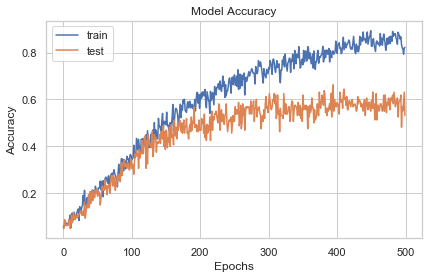

In [18]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

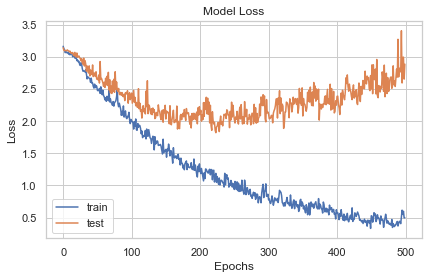

In [19]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [20]:
def draw_rectangle(img, rect):
    (x, y, w, h) = rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

In [21]:
def draw_text(img, text, x, y):
    cv2.putText(img, text, (x, y), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 255, 0), 2)

In [22]:
def predict(test_img):
    IMG_SIZE=32
    img = test_img.copy()
    face, rect = detect_face(img) 
    img2 = cv2.resize(face,(IMG_SIZE,IMG_SIZE))
    img1=img2.reshape(-3,IMG_SIZE,IMG_SIZE,3)
    label = model.predict(img1)
    label_text = subjects[np.argmax((label[0]))]
    draw_rectangle(img, rect)
    draw_text(img, label_text, rect[0], rect[1]-5)
    return img

In [23]:
def prepare (filepath):
    IMG_SIZE=32;
    #img_array=cv2.imread(filepath,cv2.IMREAD_COLOR)
    new_array=cv2.resize(filepath,(32,32))
    return new_array.reshape(-3,32,32,3)

In [24]:
test_img1 = cv2.imread('C:/Users/ntadi/Desktop/New folder (2)/test/test-4.jpeg')
test_img2 = cv2.imread('C:/Users/ntadi/Desktop/New folder (2)/test/test-7.jpeg')
test_img3 = cv2.imread('C:/Users/ntadi/Desktop/New folder (2)/test/tnr.jpeg')
test_img4 = cv2.imread('C:/Users/ntadi/Desktop/New folder (2)/test/tnr2.jpeg')

In [25]:
predicted_img1 = predict(test_img1)
predicted_img2 = predict(test_img2)
predicted_img3 = predict(test_img3)
predicted_img4 = predict(test_img4)
print("Prediction complete")

Prediction complete


In [ ]:
cv2.imshow(subjects[0], predicted_img1)
cv2.imshow(subjects[1], predicted_img2)
cv2.imshow(subjects[2], predicted_img3)
cv2.imshow(subjects[3], predicted_img4)
cv2.waitKey(0)
cv2.destroyAllWindows()